In [1]:
import pandas as pd
df_fuel = pd.read_csv('/content/real_monthly_petrol_prices.csv')



In [2]:
df_metro = pd.read_csv('/content/metro_ridership_data.csv' , encoding ='latin')

In [3]:
# Drop 'Source' and 'URL' columns from metro ridership dataframe
df_metro = df_metro.drop(columns=['Source', 'URL'])

# Confirm the result
df_metro.head()


,City,Month,Ridership (Million)
0,Bengaluru,2023-April,0.96
1,Bengaluru,2023-August,0.90
2,Bengaluru,2023-December,0.75
3,Bengaluru,2023-February,0.80
4,Bengaluru,2023-January,2.50


Standardize the Month format in both datasets

In [4]:
df_fuel['Month'] = pd.to_datetime(df_fuel['Month']).dt.to_period('M').astype(str)
df_metro['Month'] = pd.to_datetime(df_metro['Month']).dt.to_period('M').astype(str)


/tmp/ipython-input-4-2094051141.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_metro['Month'] = pd.to_datetime(df_metro['Month']).dt.to_period('M').astype(str)


Merge the datasets on City and Month

In [5]:
df_merged = pd.merge(df_fuel, df_metro, on=["City", "Month"], how="inner")


Check for null values

In [6]:
print("Null values per column:\n", df_merged.isnull().sum())


Null values per column:
 Month                  0
City                   0
Petrol Price           0
Ridership (Million)    0
dtype: int64


Check number of records per city

In [7]:
print("\nRecord counts per city:\n", df_merged['City'].value_counts())



Record counts per city:
 City
Delhi        18
Mumbai       18
Bengaluru    18
Name: count, dtype: int64


Check number of unique values for price and ridership

In [8]:
for city in df_merged['City'].unique():
    df_city = df_merged[df_merged['City'] == city]
    print(f"\n{city} — Unique values")
    print("  Petrol Price:", df_city['Petrol Price'].nunique())
    print("  Ridership   :", df_city['Ridership (Million)'].nunique())



Delhi — Unique values
  Petrol Price: 13
  Ridership   : 10

Mumbai — Unique values
  Petrol Price: 14
  Ridership   : 10

Bengaluru — Unique values
  Petrol Price: 12
  Ridership   : 9


Variance Check

In [9]:
print("\nVariance check:")
print(df_merged.groupby('City')[['Petrol Price', 'Ridership (Million)']].var())



Variance check:
           Petrol Price  Ridership (Million)
City                                        
Bengaluru      0.211115             0.489894
Delhi          0.077991         12777.594022
Mumbai         0.175603          7275.023872


Anomaly Detection / Outlier Flagging

In [10]:
mean_rider = df_merged['Ridership (Million)'].mean()
std_rider = df_merged['Ridership (Million)'].std()

df_merged['Ridership_Outlier'] = df_merged['Ridership (Million)'] > (mean_rider + 2 * std_rider)

# View flagged rows
df_merged[df_merged['Ridership_Outlier']]


,Month,City,Petrol Price,Ridership (Million),Ridership_Outlier
0,2023-01,Delhi,96.72,355.3,True
11,2023-12,Delhi,96.89,355.3,True
30,2024-01,Mumbai,106.71,355.3,True


Impute Outliers

In [11]:
df_cleaned = df_merged.copy()

for city in df_cleaned['City'].unique():
    median_val = df_cleaned.loc[(df_cleaned['City'] == city) & (~df_cleaned['Ridership_Outlier']), 'Ridership (Million)'].median()
    df_cleaned.loc[(df_cleaned['City'] == city) & (df_cleaned['Ridership_Outlier']), 'Ridership (Million)'] = median_val


Add Monthly % Change Columns

In [12]:
df_cleaned['Petrol Change %'] = df_cleaned.groupby('City')['Petrol Price'].pct_change() * 100
df_cleaned['Ridership Change %'] = df_cleaned.groupby('City')['Ridership (Million)'].pct_change() * 100


Final Cleanliness Check

In [13]:
print(df_cleaned.isnull().sum())
print(df_cleaned.duplicated().sum())
print(df_cleaned.dtypes)


Month                  0
City                   0
Petrol Price           0
Ridership (Million)    0
Ridership_Outlier      0
Petrol Change %        3
Ridership Change %     3
dtype: int64
0
Month                   object
City                    object
Petrol Price           float64
Ridership (Million)    float64
Ridership_Outlier         bool
Petrol Change %        float64
Ridership Change %     float64
dtype: object


Re-check Variance

In [14]:
df_cleaned.groupby('City')[['Petrol Price', 'Ridership (Million)']].var()


,Petrol Price,Ridership (Million)
City,,
Bengaluru,0.211115,0.489894
Delhi,0.077991,6.197567
Mumbai,0.175603,545.881646


Double-check Mumbai’s highest ridership value:

In [15]:
df_cleaned[df_cleaned['City'] == 'Mumbai'].sort_values('Ridership (Million)', ascending=False)


,Month,City,Petrol Price,Ridership (Million),Ridership_Outlier,Petrol Change %,Ridership Change %
34,2024-05,Mumbai,107.20,100.00,False,-0.195513,34382.758621
19,2023-02,Mumbai,106.31,9.00,False,0.000000,3003.448276
28,2023-11,Mumbai,106.54,4.77,False,0.310705,914.893617
32,2024-03,Mumbai,107.10,3.67,False,0.177720,267.000000
31,2024-02,Mumbai,106.91,1.00,False,0.187424,112.765957
20,2023-03,Mumbai,106.31,0.48,False,0.000000,-94.666667
30,2024-01,Mumbai,106.71,0.47,True,0.159564,261.538462
22,2023-05,Mumbai,106.67,0.47,False,0.150221,62.068966
27,2023-10,Mumbai,106.21,0.47,False,0.188661,62.068966
25,2023-08,Mumbai,107.21,0.47,False,0.000000,62.068966


Re-impute all large values > 5

In [16]:
# Replacing Mumbai's outlier ridership values > 5 with city-wise median
median_mumbai = df_cleaned[(df_cleaned['City'] == 'Mumbai') & (df_cleaned['Ridership (Million)'] <= 5)]['Ridership (Million)'].median()

df_cleaned.loc[(df_cleaned['City'] == 'Mumbai') & (df_cleaned['Ridership (Million)'] > 5), 'Ridership (Million)'] = median_mumbai


Re check of variance

In [17]:
df_cleaned.groupby('City')[['Petrol Price', 'Ridership (Million)']].var()


,Petrol Price,Ridership (Million)
City,,
Bengaluru,0.211115,0.489894
Delhi,0.077991,6.197567
Mumbai,0.175603,1.599559


Data Integrity check

Step 1: Confirm Columns & Types

In [18]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Month                54 non-null     object 
 1   City                 54 non-null     object 
 2   Petrol Price         54 non-null     float64
 3   Ridership (Million)  54 non-null     float64
 4   Ridership_Outlier    54 non-null     bool   
 5   Petrol Change %      51 non-null     float64
 6   Ridership Change %   51 non-null     float64
dtypes: bool(1), float64(4), object(2)
memory usage: 2.7+ KB


Step 2: Null Value Check

In [19]:
df_cleaned.isnull().sum()


,0
Month,0
City,0
Petrol Price,0
Ridership (Million),0
Ridership_Outlier,0
Petrol Change %,3
Ridership Change %,3


All should be 0 except first rows of % change columns (NaN is expected)

Step 3: Duplicates Check

In [20]:
df_cleaned.duplicated().sum()


np.int64(0)

Step 4: Consistency of Records Per City

In [21]:
df_cleaned['City'].value_counts()


,count
City,
Delhi,18
Mumbai,18
Bengaluru,18


Step 5: Time Period Sanity Check

In [22]:
df_cleaned['Month'].unique()


array(['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
       '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12',
       '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06'],
      dtype=object)

In [23]:
df_cleaned['Month'].nunique()  # Should be 18


18

Step 6: Final Outlier Confirmation

In [24]:
df_cleaned[df_cleaned['Ridership (Million)'] > 10]  # Nothing extreme now


,Month,City,Petrol Price,Ridership (Million),Ridership_Outlier,Petrol Change %,Ridership Change %


Step 7: Final Variance Check

In [25]:
df_cleaned.groupby('City')[['Petrol Price', 'Ridership (Million)']].var()


,Petrol Price,Ridership (Million)
City,,
Bengaluru,0.211115,0.489894
Delhi,0.077991,6.197567
Mumbai,0.175603,1.599559


Step 8: Final Stats Overview

In [26]:
df_cleaned.describe(include='all')


,Month,City,Petrol Price,Ridership (Million),Ridership_Outlier,Petrol Change %,Ridership Change %
count,54,54,54.000000,54.000000,54,51.000000,51.000000
unique,18,3,NaN,NaN,2,NaN,NaN
top,2023-01,Delhi,NaN,NaN,False,NaN,NaN
freq,3,18,NaN,NaN,51,NaN,NaN
mean,NaN,NaN,101.796667,2.678889,NaN,0.030377,786.577853
std,NaN,NaN,4.042900,2.873604,NaN,0.318186,4821.792910
min,NaN,NaN,96.500000,0.130000,NaN,-1.380864,-99.710000
25%,NaN,NaN,97.142500,0.470000,NaN,0.000000,-38.940603
50%,NaN,NaN,101.900000,0.920000,NaN,0.103391,0.000000
75%,NaN,NaN,106.310000,4.577500,NaN,0.202556,62.068966


Data Visualisation and Correaltion Analysis

1. City-wise Correlation Calculation

In [27]:
# Correlation between Petrol Price and Ridership per city
correlation_summary = df_cleaned.groupby('City').apply(
    lambda group: group[['Petrol Price', 'Ridership (Million)']].corr().iloc[0, 1]
).reset_index()
correlation_summary.columns = ['City', 'Correlation (Petrol vs. Ridership)']

print(correlation_summary)


        City  Correlation (Petrol vs. Ridership)
0  Bengaluru                            0.087535
1      Delhi                           -0.626443
2     Mumbai                            0.042346


/tmp/ipython-input-27-1546585145.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_summary = df_cleaned.groupby('City').apply(


P-values

In [28]:
from scipy.stats import pearsonr

for city in df_cleaned['City'].unique():
    subset = df_cleaned[df_cleaned['City'] == city]
    corr, p_value = pearsonr(subset['Petrol Price'], subset['Ridership (Million)'])
    print(f"{city} → Corr: {corr:.3f}, P-value: {p_value:.4f}")


Delhi → Corr: -0.626, P-value: 0.0054
Mumbai → Corr: 0.042, P-value: 0.8675
Bengaluru → Corr: 0.088, P-value: 0.7298


2. Summary Statistics Table by City

In [30]:
summary_table = df_cleaned.groupby('City').agg({
    'Petrol Price': ['mean', 'std', 'min', 'max'],
    'Ridership (Million)': ['mean', 'std', 'min', 'max'],
    'Month': 'count'
}).reset_index()

summary_table.columns = ['City', 'Petrol_Mean', 'Petrol_Std', 'Petrol_Min', 'Petrol_Max',
                         'Ridership_Mean', 'Ridership_Std', 'Ridership_Min', 'Ridership_Max',
                         'Total_Months']

print(summary_table)


        City  Petrol_Mean  Petrol_Std  Petrol_Min  Petrol_Max  Ridership_Mean  \
0  Bengaluru   101.677222    0.459473      100.70      102.21        1.233333   
1      Delhi    96.974444    0.279268       96.50       97.52        5.985556   
2     Mumbai   106.738333    0.419050      106.01      107.41        0.817778   

   Ridership_Std  Ridership_Min  Ridership_Max  Total_Months  
0       0.699924           0.75           2.50            18  
1       2.489491           0.29           9.00            18  
2       1.264737           0.13           4.77            18  


3. Automated Insight Generator

In [31]:
for index, row in correlation_summary.iterrows():
    city = row['City']
    corr = row['Correlation (Petrol vs. Ridership)']
    print(f"🔍 In {city}, the correlation between petrol price and ridership is {corr:.3f}.")

    if abs(corr) < 0.3:
        print(f"   ➤ This indicates a weak or negligible relationship — price may not influence ridership directly.\n")
    elif 0.3 <= abs(corr) < 0.7:
        print(f"   ➤ Moderate correlation — changes in fuel prices may influence ridership to some extent.\n")
    else:
        print(f"   ➤ Strong correlation — fluctuations in fuel prices likely affect metro ridership behavior.\n")


🔍 In Bengaluru, the correlation between petrol price and ridership is 0.088.
   ➤ This indicates a weak or negligible relationship — price may not influence ridership directly.

🔍 In Delhi, the correlation between petrol price and ridership is -0.626.
   ➤ Moderate correlation — changes in fuel prices may influence ridership to some extent.

🔍 In Mumbai, the correlation between petrol price and ridership is 0.042.
   ➤ This indicates a weak or negligible relationship — price may not influence ridership directly.



Correlation Heatmap

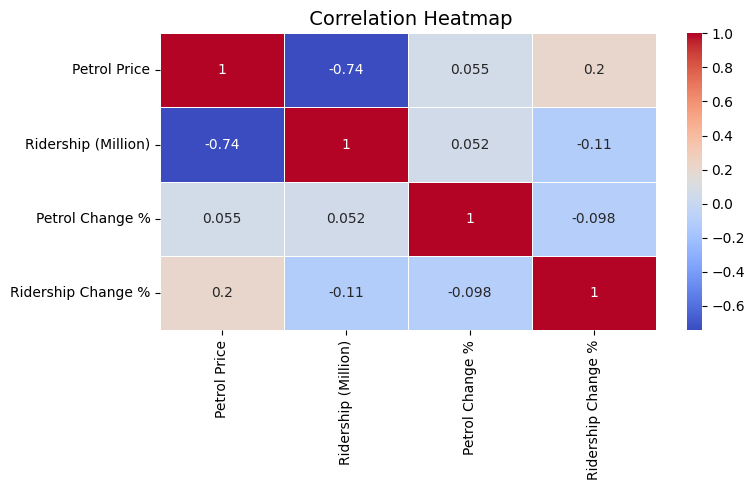

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(df_cleaned[['Petrol Price', 'Ridership (Million)', 'Petrol Change %', 'Ridership Change %']].corr(),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(" Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


 Monthly Seasonality Plot

In [33]:
# Ensure Month is in datetime format
df_cleaned['Month'] = pd.to_datetime(df_cleaned['Month'], errors='coerce')

# Extract numeric month (1 = Jan, ..., 12 = Dec)
df_cleaned['Month_Num'] = df_cleaned['Month'].dt.month


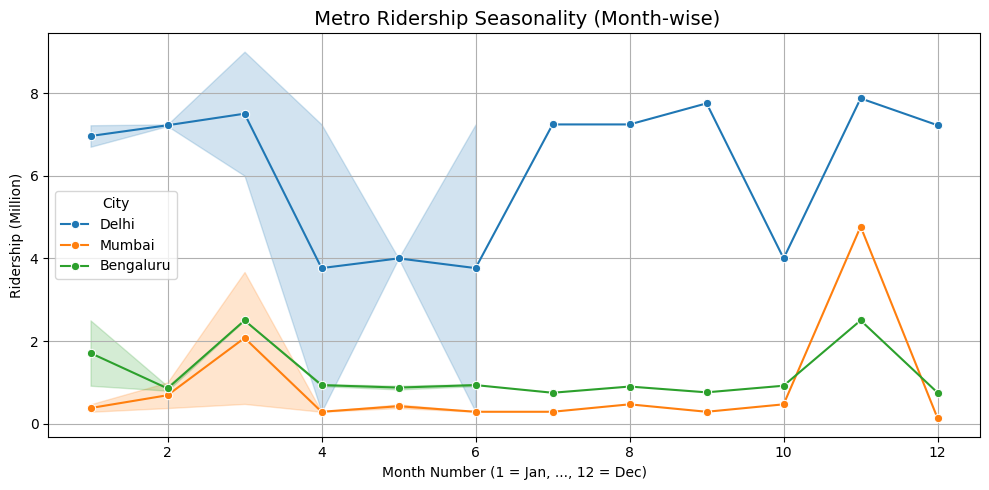

In [34]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_cleaned, x='Month_Num', y='Ridership (Million)', hue='City', marker='o')
plt.title(" Metro Ridership Seasonality (Month-wise)", fontsize=14)
plt.xlabel("Month Number (1 = Jan, ..., 12 = Dec)")
plt.ylabel("Ridership (Million)")
plt.grid(True)
plt.tight_layout()
plt.show()


% Change Comparison: Petrol vs Ridership

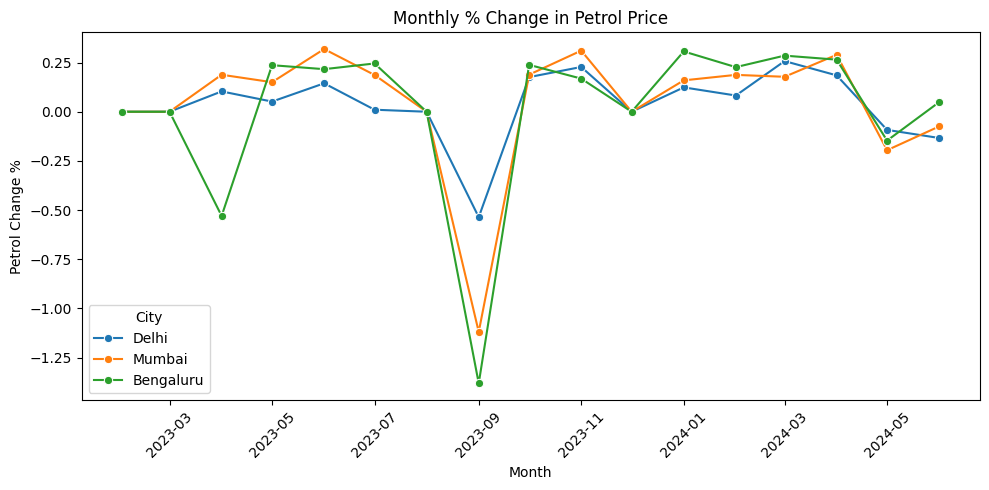

In [46]:
plt.figure(figsize=(10, 5))

sns.lineplot(data=df_cleaned, x='Month', y='Petrol Change %', hue='City', marker='o')
plt.title("Monthly % Change in Petrol Price")
plt.ylabel("Petrol Change %")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Scatter Plot: Petrol Price vs Ridership (with Trendline)

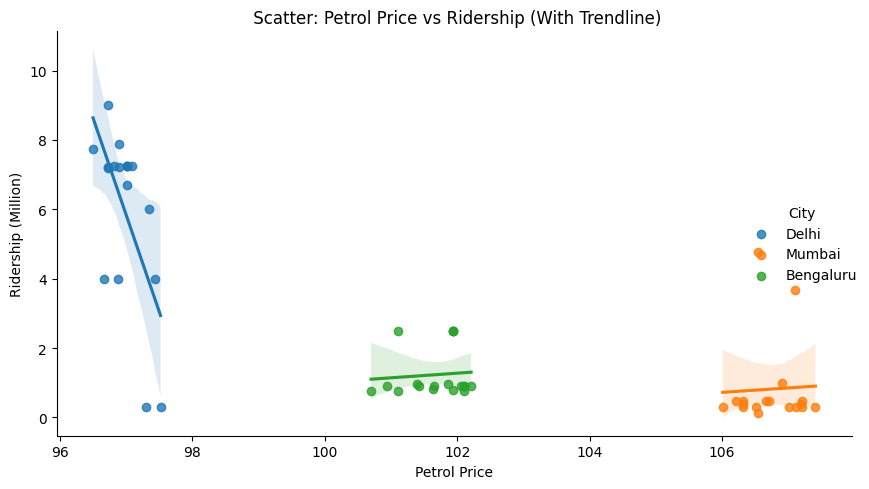

In [36]:
sns.lmplot(data=df_cleaned, x='Petrol Price', y='Ridership (Million)', hue='City', height=5, aspect=1.5)
plt.title(" Scatter: Petrol Price vs Ridership (With Trendline)")
plt.tight_layout()
plt.show()


Bar Plot: Avg Ridership per City

/tmp/ipython-input-38-3481449511.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cleaned, x='City', y='Ridership (Million)', estimator='mean', ci=None)


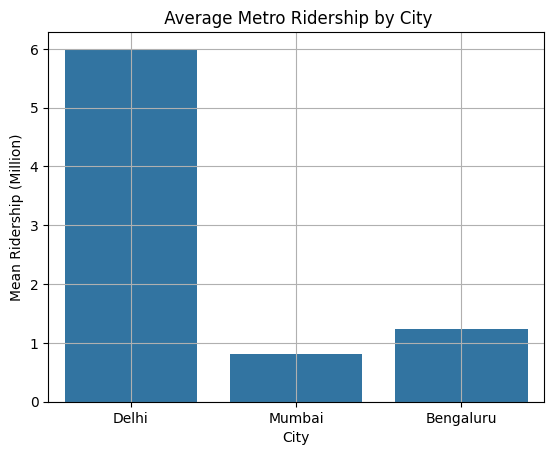

In [38]:
sns.barplot(data=df_cleaned, x='City', y='Ridership (Million)', estimator='mean', ci=None)
plt.title(" Average Metro Ridership by City")
plt.ylabel("Mean Ridership (Million)")
plt.grid(True)
plt.show()


3. Boxplot for Ridership Outlier Detection

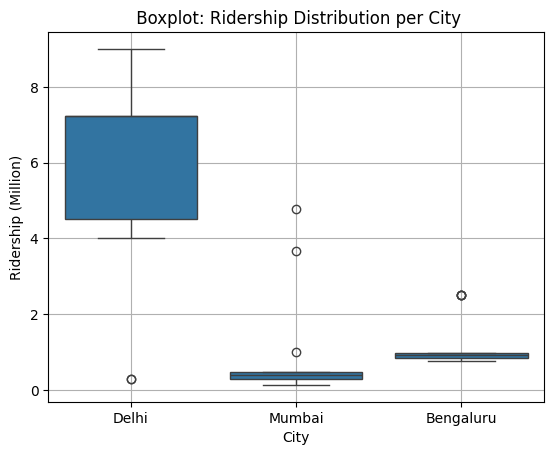

In [39]:
sns.boxplot(data=df_cleaned, x='City', y='Ridership (Million)')
plt.title(" Boxplot: Ridership Distribution per City")
plt.ylabel("Ridership (Million)")
plt.grid(True)
plt.show()


Regression Analysis – Only for Delhi

Ridership = β₀ + β₁ × Petrol_Price + ε

In [41]:
import statsmodels.api as sm

# Delhi only
delhi_df = df_cleaned[df_cleaned['City'] == 'Delhi']

X = delhi_df['Petrol Price']
y = delhi_df['Ridership (Million)']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     Ridership (Million)   R-squared:                       0.392
Model:                             OLS   Adj. R-squared:                  0.354
Method:                  Least Squares   F-statistic:                     10.33
Date:                 Sat, 12 Jul 2025   Prob (F-statistic):            0.00541
Time:                         10:11:25   Log-Likelihood:                -36.959
No. Observations:                   18   AIC:                             77.92
Df Residuals:                       16   BIC:                             79.70
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          547.5222    168.456    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


Regression Line to Delhi Scatter Plot

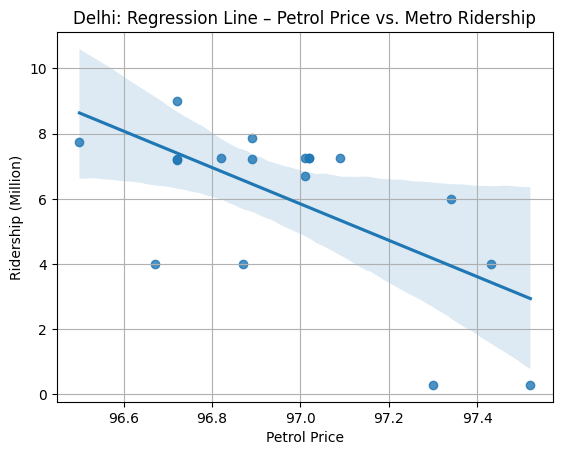

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=delhi_df, x='Petrol Price', y='Ridership (Million)', ci=95)
plt.title('Delhi: Regression Line – Petrol Price vs. Metro Ridership')
plt.grid(True)
plt.show()
